In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
tokenizer = AutoTokenizer.from_pretrained("joeddav/xlm-roberta-large-xnli")
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/constraint_hindi_train.csv")
taglist = list()
for i in range(len(df)):
    tags = df.iloc[i]["Labels Set"].split(",")
    for tag in tags:
        if(tag not in taglist):
            taglist.append(tag)

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        
        self.df = pd.read_csv(datapath)
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        sentence = self.df.iloc[idx]["Post"]
        encoding = tokenizer.encode_plus(sentence,add_special_tokens=True,max_length=64,truncation=True,pad_to_max_length=True,return_attention_mask=True)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        labels = np.zeros(5)
        tags = self.df.iloc[idx]["Labels Set"].split(",")
        for tag in tags:
            labels[taglist.index(tag)] = 1
        return np.array(input_ids), np.array(attention_mask), labels
trainset = Dataset("../data/constraint_hindi_train.csv")
valset = Dataset("../data/constraint_hindi_valid.csv")

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True, pin_memory=True,num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle=False, pin_memory=True,num_workers=4)

In [4]:
class bert_model(nn.Module): ## CNN + Linear (single linear)
    def __init__(self):
        super(bert_model, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained("joeddav/xlm-roberta-large-xnli", output_hidden_states=True)
        self.bert = torch.nn.Sequential(*(list(self.bert.children())[:-1]))
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 1024), padding=(1,0)) for i in range(24)])
        self.pools = nn.ModuleList([nn.MaxPool1d(kernel_size=64) for i in range(24)])
        self.linear = nn.Linear(in_features=24, out_features=5)
        self.sigmoid = nn.Sigmoid()
    def forward(self,sent):
        x = model.bert[0].embeddings(sent.to("cuda:2"))
        seq = x.unsqueeze(dim=1)
        for i in range(len(model.bert[0].encoder.layer)):
            device = torch.device("cuda:"+str((i+2)%4))
            x = model.bert[0].encoder.layer[i](x.to(device))[0]
            temp = x.unsqueeze(dim=1)
            seq = seq.to(device)
            seq = torch.cat((seq,temp),dim=1)
        seq = torch.transpose(seq,0,1)
        hidden_states = seq[1:].to("cuda:2")
        cnn_out = torch.empty(0,dtype = torch.float).to("cuda:2")
        for i, state in enumerate(hidden_states):
            state = torch.unsqueeze(state, dim=1)
            out = self.convs[i](state)
            out = out.squeeze(dim=3)
            out = self.pools[i](out) 
            out = out.squeeze(dim=2) 
            cnn_out = torch.cat([cnn_out, out], dim=1)

        seq = self.linear(cnn_out)
        seq = self.sigmoid(seq)
        return seq

In [4]:
model = bert_model()

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
for param in model.parameters():
    param.requires_grad=True

In [6]:
for i in range(len(model.bert[0].encoder.layer)):
    device = torch.device("cuda:"+str((i+2)%4))
    model.bert[0].encoder.layer[i]=model.bert[0].encoder.layer[i].to(device)
model.bert[0].embeddings = model.bert[0].embeddings.to("cuda:2")
model.convs = model.convs.to("cuda:2")
model.linear.to("cuda:2")

Linear(in_features=24, out_features=5, bias=True)

In [7]:
train_losses = list()
val_losses=list()
val_accuracy=list()
loss = nn.BCELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
for epoch in (range(10)):
    model.train()
    total_loss=0
    num_batches = 0
    for batch in tqdm(trainloader):
#         optimizer.zero_grad() 
        for param in model.parameters():
            param.grad = None ## using instead of optimizer.zero_grad
        logits = model(batch[0]).to("cuda:2")
        labels = batch[2].to("cuda:2")

        loss_value = loss(logits.float(),labels.float())
        loss_value.backward()
        optimizer.step()

        total_loss+=loss_value.item()
        num_batches +=1
        torch.cuda.empty_cache()
    train_losses.append(total_loss/num_batches)
    if(epoch%1==0):
        print("train loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))

    model.eval()
    total_loss=0
    num_batches = 0
    for batch in tqdm(valloader):
        logits = model(batch[0])
        labels = batch[2]

        loss_value = loss(logits.float().to("cuda:2"),labels.float().to("cuda:2"))
        total_loss+=loss_value.item()
        num_batches +=1
        torch.cuda.empty_cache()
    val_losses.append(total_loss/num_batches)
    if(epoch%1==0):
        print("val loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))
        
    logits_list = np.zeros((1,5))
    labels_list = np.zeros((1,5))
    for batch in (valloader):
        logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
        labels = batch[2].to("cpu")
    
        logits_list = np.concatenate((logits_list,logits),0)
        labels_list = np.concatenate((labels_list,labels),0)
    
        torch.cuda.empty_cache()
    val_accuracy.append(f1_score(labels_list[1:], logits_list[1:], average='weighted'))
    if(epoch%1==0):
        print("val accuracy after epoch "+str(epoch)+ " : " + str(f1_score(labels_list[1:], logits_list[1:], average='weighted')))
 

  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 0:0.41356154878934226


100%|██████████| 811/811 [00:33<00:00, 24.46it/s]

val loss at epoch 0:0.3176744584724509



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 0 : 0.5271139713946705


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 1:0.2905615917510457


100%|██████████| 811/811 [00:33<00:00, 24.05it/s]

val loss at epoch 1:0.27410739653143207



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 1 : 0.613952038948411


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 2:0.2552066905630959


100%|██████████| 811/811 [00:32<00:00, 24.78it/s]

val loss at epoch 2:0.2454225296205146



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 2 : 0.6600210284620417


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 3:0.22672638379865223


100%|██████████| 811/811 [00:33<00:00, 24.28it/s]

val loss at epoch 3:0.23380933333826787



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 3 : 0.6799824600883121


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 4:0.20701457891199324


100%|██████████| 811/811 [00:33<00:00, 24.04it/s]

val loss at epoch 4:0.23382937371829562



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 4 : 0.7055816663983341


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 5:0.18966909382078384


100%|██████████| 811/811 [00:33<00:00, 24.06it/s]

val loss at epoch 5:0.2184130644521064



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 5 : 0.7421778272224029


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 6:0.17276375815272332


100%|██████████| 811/811 [00:33<00:00, 23.94it/s]

val loss at epoch 6:0.2269649286829073



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 6 : 0.750527627035005


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 7:0.16199682636393442


100%|██████████| 811/811 [00:33<00:00, 24.08it/s]

val loss at epoch 7:0.22448249652628063



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 7 : 0.7665723689982549


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 8:0.14483755744165844


100%|██████████| 811/811 [00:33<00:00, 24.23it/s]

val loss at epoch 8:0.2285420579104265



  0%|          | 0/90 [00:00<?, ?it/s]

val accuracy after epoch 8 : 0.7529917391493629


  0%|          | 0/811 [00:00<?, ?it/s]

train loss at epoch 9:0.1305747395588292


100%|██████████| 811/811 [00:33<00:00, 24.13it/s]

val loss at epoch 9:0.23518478251768576


val accuracy after epoch 9 : 0.7758848860976065


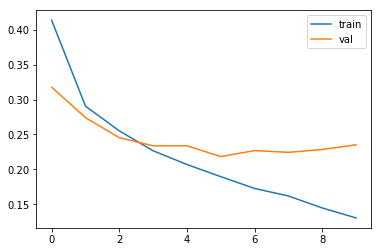

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()

In [15]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
logits_list = np.zeros((1,5))
labels_list = np.zeros((1,5))
model.eval()
for batch in (trainloader):
    batch[0],batch[1],batch[2] = batch[0].to(device), batch[1].to(device), batch[2].to(device)
    logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
    labels = batch[2].to("cpu").numpy()

    # batch[0]= batch[0].to(device)
    # logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
    # labels = batch[1].to("cpu").numpy()
    
    logits_list = np.concatenate((logits_list,logits),0)
    labels_list = np.concatenate((labels_list,labels),0)
    
    torch.cuda.empty_cache()
print(precision_score(labels_list[1:], logits_list[1:], average='weighted'))
print(recall_score(labels_list[1:], logits_list[1:], average='weighted'))
print(f1_score(labels_list[1:], logits_list[1:], average='weighted'))

0.9493765864072027
0.8978067387158296
0.9183211458397436


In [18]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
logits_list = np.zeros((1,5))
labels_list = np.zeros((1,5))
model.eval()
for batch in (valloader):
    batch[0],batch[1],batch[2] = batch[0].to(device), batch[1].to(device), batch[2].to(device)
    logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
    labels = batch[2].to("cpu").numpy()

    # batch[0]= batch[0].to(device)
    # logits = model(batch[0]).to("cpu").detach().numpy() > 0.5
    # labels = batch[1].to("cpu").numpy()
    
    logits_list = np.concatenate((logits_list,logits),0)
    labels_list = np.concatenate((labels_list,labels),0)
    
    torch.cuda.empty_cache()
print(precision_score(labels_list[1:], logits_list[1:], average='weighted'))
print(recall_score(labels_list[1:], logits_list[1:], average='weighted'))
print(f1_score(labels_list[1:], logits_list[1:], average='weighted'))

0.8006832953360798
0.7559322033898305
0.7758848860976065


In [19]:
def print_conf(y_true,y_pred,i):
    y_true = labels_list[:,i]
    y_pred = logits_list[:,i]
    matrix_hate = np.zeros((2,2))
    for i in range(len(y_true)):
        true = int(y_true[i])
        pred = int(y_pred[i])
        matrix_hate[true][pred]+=1
    print(matrix_hate)
##coordinate 0 hate
for i in range(5):
    y_true = labels_list[:,i]
    y_pred = logits_list[:,i]
    print_conf(y_true,y_pred,i)

[[651.  51.]
 [ 55.  55.]]
[[679.  30.]
 [ 53.  50.]]
[[365.  12.]
 [ 21. 414.]]
[[708.  27.]
 [ 52.  25.]]
[[620.  32.]
 [ 35. 125.]]


In [16]:
## final_inference on test data

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        
        self.df = pd.read_csv(datapath)
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        sentence = self.df.iloc[idx]["Post"]
        encoding = tokenizer.encode_plus(sentence,add_special_tokens=True,max_length=64,truncation=True,pad_to_max_length=True,return_attention_mask=True)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        uid = int(self.df.iloc[idx]["Unique ID"])
        return np.array(input_ids), np.array(attention_mask), uid
testset = test_dataset("../data/test.csv")
testloader = torch.utils.data.DataLoader(testset, batch_size = 1)
model.eval()
final_result = list()
for batch in tqdm(testloader):
    labels = list()
    x = model(batch[0]).to("cpu").detach().numpy()[0]
    if(x[0]>0.5):
        labels.append("hate")
    if(x[1]>0.5):
        labels.append("offensive")
    if(x[2]>0.5):
        labels.append("non-hostile")
    if(x[3]>0.5):
        labels.append("defamation")
    if(x[4]>0.5):
        labels.append("fake")
    if(labels==[]):
        labels = taglist[np.argmin(np.array(x))]
    final_result.append((batch[2].item(),labels))

100%|██████████| 1653/1653 [01:00<00:00, 27.10it/s]


In [17]:
final_result

[(1, 'fake'),
 (2, ['non-hostile']),
 (3, ['hate']),
 (4, ['fake']),
 (5, ['hate']),
 (6, ['non-hostile']),
 (7, ['non-hostile']),
 (8, ['hate', 'offensive']),
 (9, ['fake']),
 (10, ['defamation']),
 (11, ['fake']),
 (12, ['defamation']),
 (13, ['non-hostile']),
 (14, ['hate']),
 (15, ['hate', 'offensive']),
 (16, ['fake']),
 (17, 'offensive'),
 (18, ['non-hostile']),
 (19, ['hate']),
 (20, ['hate', 'offensive']),
 (21, ['non-hostile']),
 (22, 'offensive'),
 (23, ['non-hostile']),
 (24, ['non-hostile']),
 (25, ['non-hostile']),
 (26, ['hate']),
 (27, ['hate', 'offensive']),
 (28, ['offensive']),
 (29, ['offensive', 'defamation']),
 (30, ['non-hostile']),
 (31, ['non-hostile']),
 (32, ['non-hostile']),
 (33, ['fake']),
 (34, ['fake']),
 (35, ['non-hostile']),
 (36, ['non-hostile']),
 (37, ['non-hostile']),
 (38, ['non-hostile']),
 (39, ['defamation']),
 (40, ['non-hostile']),
 (41, ['non-hostile']),
 (42, ['non-hostile']),
 (43, ['non-hostile']),
 (44, ['non-hostile']),
 (45, ['fake']),